In [9]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev

import pycutest


from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from tqdm import tqdm

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import sys
sys.path.append("..")
from Functions import PyCutestWrapper, PyCutestGetter
from AdaptiveFD import adapt_FD
from pow_sampling_set import create_approx_S

In [151]:
def simplex_gradient(F, x_0, S, jrandom_key_f):
    num_func_calls = 0
    jrandom_key, subkey = jrandom.split(jrandom_key_f)
    FS = []
    for s_i in S.T:
        jrandom_key, subkey = jrandom.split(jrandom_key)
        FS.append(F.f(s_i + x_0, subkey))
        num_func_calls += 1
    FS = jnp.array(FS)
    jrandom_key, subkey = jrandom.split(jrandom_key)
    F_x_0 = F.f(x_0, subkey)
    num_func_calls += 1
    SS_inv = jnp.linalg.inv(S.dot(S.T))
    return SS_inv.dot(S.dot(FS - F_x_0)), num_func_calls




In [258]:

# eps = 0.1
sig = 0.01 # eps/jnp.sqrt(3)
eps = sig * jnp.sqrt(3)
noise_type = "uniform"
jrandom_key = jrandom.PRNGKey(0)



_, x_0, F = PyCutestGetter(4, eps, noise_type) # pycutest.import_problem("QUARTC")

coeff = .1 * len(x_0)
H = F.f2(x_0)



In [228]:


def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def loss_getter(dim, N, H, sig, coeff):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + coeff*jnp.linalg.norm(S)**4

    return helper

def optimize_uncentered_S(H, sig, coeff, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eig(H)
    U = jnp.real(U)

    # print("D", repr(jnp.real(D)))
#     D = jnp.abs(jnp.real(jnp.diag(D)))
    D = jnp.diag(D)

    if x_curr is None:

        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
        

    
    l = loss_getter(dim, N, D, sig, coeff)
    g_l = grad(l)
    h_l = jacfwd(g_l)
    linesearch = helper_linesearch(l, g_l, c1=0.1, c2=0.9)

    eps = 1e-20

    res = []
    res_x = []

    for t in tqdm(range(max_steps)):

        
        res.append(l(x_curr))
#         res_x.append(U.dot(x_curr.reshape(N, dim).T)) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
#         print(curr_grad)
    
        # print(curr_grad)
#         curr_hess = h_l(x_curr) + 10*jnp.eye(dim**2)
#         search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(dim**2))*0.1
        search_direction = -curr_grad + np.random.normal(size=(dim * dim))*0.1

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)


        S = x_curr.reshape(N, dim).T

        SS = S.dot(S.T)

        x_curr += alpha*search_direction 
    
    return U.dot(x_curr.reshape(N, dim).T), res

In [259]:
pow_S = create_approx_S(H, sig, coeff)


In [230]:
jnp.linalg.svd(pow_S)

(DeviceArray([[-0.56782602, -0.12077836,  0.71701966,  0.38387151,
               -0.03888029],
              [-0.32845181, -0.85098683, -0.40883139,  0.00728071,
               -0.02728919],
              [ 0.69297634, -0.50838248,  0.50305692, -0.0790808 ,
               -0.04484431],
              [-0.09747424,  0.0434688 ,  0.04527115, -0.31062402,
               -0.94343653],
              [ 0.28279955,  0.02986163, -0.2522379 ,  0.86593799,
               -0.32505404]], dtype=float64),
 DeviceArray([0.24386478, 0.05555938, 0.04243675, 0.0281082 , 0.01728417],            dtype=float64),
 DeviceArray([[ 5.00000000e-01,  5.00000000e-01,  8.23005210e-18,
                5.00000000e-01,  5.00000000e-01],
              [-5.00000000e-01,  5.00000000e-01, -4.35703449e-16,
               -5.00000000e-01,  5.00000000e-01],
              [ 0.00000000e+00,  1.32607383e-15,  1.00000000e+00,
               -3.70833795e-16, -9.72877317e-16],
              [ 5.00000000e-01,  5.00000000e-01, -1.4

In [206]:
l(pow_S.T.flatten())

DeviceArray(4090.68734459, dtype=float64)

In [241]:
jrandom_key = jrandom.PRNGKey(12)
jrandom_key, subkey = jrandom.split(jrandom_key)

H = F.f2(x_0)

dim = len(H)

l = loss_getter(dim, dim, H, sig, coeff)
g_l = grad(l)

# opt_S, l_hist = optimize_uncentered_S(H, sig=sig, coeff=coeff, max_steps=10, jrandom_key=jrandom_key, x_curr=opt_S.T.flatten())



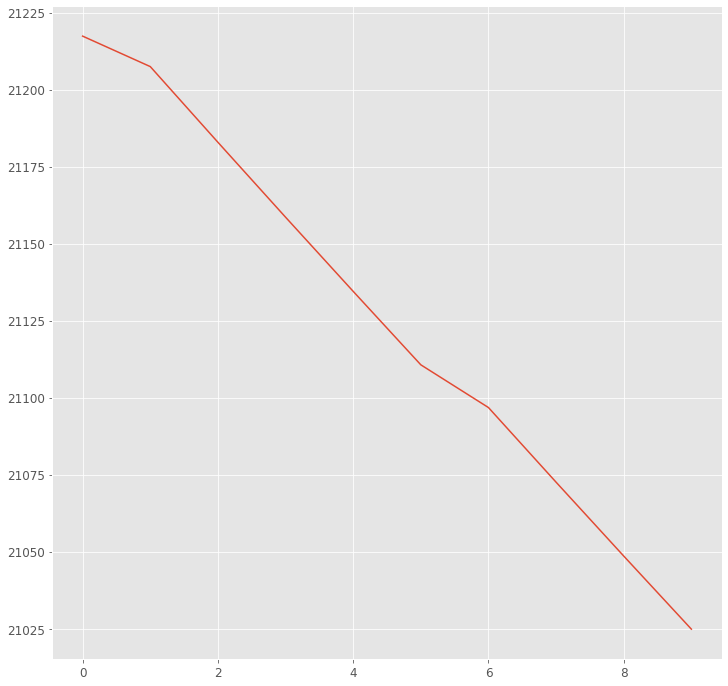

In [63]:
plt.plot(l_hist)

In [64]:
g_l(opt_S.T.flatten())

DeviceArray([ 4.63208454e+00, -8.13178843e+01,  1.36831530e+00, ...,
             -5.97924916e+03, -1.01608831e-02,  4.43765087e+02],            dtype=float64)

In [9]:
jnp.linalg.eig(jacfwd(g_l)(opt_S.T.flatten()))

[DeviceArray([ 2.11206096e+02+0.j,  1.91813110e+02+0.j,
               1.36021935e+02+0.j,  8.06275795e+01+0.j,
               7.92992130e+00+0.j,  8.55326280e-01+0.j,
              -4.05621394e-03+0.j,  1.56153062e-01+0.j,
               5.70469092e+01+0.j,  2.70548441e+01+0.j,
               3.52484843e+01+0.j,  4.48723902e+01+0.j,
               4.25669247e+01+0.j,  4.15451327e+01+0.j,
               3.89926980e+01+0.j,  3.93534169e+01+0.j], dtype=complex128),
 DeviceArray([[ 1.76963147e-01+0.j,  4.78909259e-01+0.j,
               -2.82689285e-01+0.j, -1.29173361e-01+0.j,
                7.95077501e-02+0.j, -1.83214822e-01+0.j,
                3.42330428e-01+0.j, -1.32387667e-01+0.j,
                2.62102954e-01+0.j,  6.16205626e-02+0.j,
               -2.30899931e-01+0.j, -2.96435896e-01+0.j,
               -4.01765680e-01+0.j,  1.83780117e-01+0.j,
                2.40644586e-01+0.j, -3.66132205e-02+0.j],
              [ 8.39539792e-02+0.j,  2.66995505e-01+0.j,
               -1.

In [547]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-3.43269255e-01,  3.28351735e-01,  8.23266701e-01,
               -3.10778532e-01],
              [-1.57669635e-01, -9.43711408e-01,  2.75127097e-01,
               -9.40964692e-02],
              [-9.03379783e-01,  3.99238178e-02, -2.66735445e-01,
                3.33411547e-01],
              [-2.03006090e-01,  7.49105358e-05, -4.18794965e-01,
               -8.85098469e-01]], dtype=float64),
 DeviceArray([1.01096617, 0.67607382, 0.67607382, 0.67607382], dtype=float64),
 DeviceArray([[-0.5       , -0.5       , -0.5       , -0.5       ],
              [ 0.04600649, -0.20940294,  0.76751329, -0.60411684],
              [ 0.25763312,  0.67422047, -0.31613296, -0.61572063],
              [-0.82553533,  0.50157469,  0.24694797,  0.07701267]],            dtype=float64))

In [196]:
jnp.diag(opt_S.T @ D @ opt_S)

DeviceArray([0.14260624, 0.14260624, 0.14260624, 0.14260624, 0.14260624,
             0.14260624], dtype=float64)

In [36]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-0.51204034, -0.30460385, -0.55900857, -0.57666334],
              [-0.47424182,  0.85747832,  0.1264342 , -0.15440214],
              [-0.69850683, -0.39047352,  0.47507435,  0.36595491],
              [-0.15810626,  0.1395631 , -0.66770366,  0.71393023]],            dtype=float64),
 DeviceArray([1.01096617, 0.67607382, 0.67607382, 0.67607382], dtype=float64),
 DeviceArray([[-0.5       , -0.5       , -0.5       , -0.5       ],
              [ 0.42729776,  0.04620924, -0.82970244,  0.35619544],
              [-0.75197927,  0.31141208, -0.12648721,  0.56705439],
              [ 0.04408868, -0.80677582,  0.21352949,  0.54915765]],            dtype=float64))

In [44]:
opt_S_V, opt_S_sing_vals, opt_S_U = jnp.linalg.svd(opt_S)

In [195]:
def set_loss(F, x_0, H, sig, coeff, num_runs):
    g_F = F.f1(x_0)
    def helper(S, jrandom_key):
        errs = []
        for _ in range(num_runs):
            jrandom_key, subkey = jrandom.split(jrandom_key)
            sgd = simplex_gradient(F, x_0, S, subkey)[0]
            errs.append(float(jnp.linalg.norm(sgd - g_F)**2))
        errs = jnp.array(errs)
        return jnp.mean(errs)
    return helper

In [244]:
mc_l = set_loss(F, x_0, H, sig, coeff, num_runs=50)

In [251]:
trial_S = jnp.eye(dim) * 0.0005

In [252]:
mc_l(trial_S, jrandom_key)

DeviceArray(77034.30935475, dtype=float64)

In [260]:
mc_l(pow_S, jrandom_key)

DeviceArray(165.06548232, dtype=float64)

In [201]:
jnp.linalg.eigh(H)

(DeviceArray([  -5.08353094,    4.57266158,   11.49318782,  170.32038347,
              1233.49134915], dtype=float64),
 DeviceArray([[-0.56782602,  0.12077836,  0.71701966,  0.38387151,
               -0.03888029],
              [-0.32845181,  0.85098683, -0.40883139,  0.00728071,
               -0.02728919],
              [ 0.69297634,  0.50838248,  0.50305692, -0.0790808 ,
               -0.04484431],
              [-0.09747424, -0.0434688 ,  0.04527115, -0.31062402,
               -0.94343653],
              [ 0.28279955, -0.02986163, -0.2522379 ,  0.86593799,
               -0.32505404]], dtype=float64))